## 8. 优化器 Optim

优化器通俗来说就是一种计算导数的算法。
<br/>
<br/>
**各种优化器的目的和创造它们的初衷其实就是能够让用户选择一种适合自己场景的优化器。优化器最主要的衡量指标就是优化曲线的平稳度，最好的优化器就是每一轮样本数据的优化都让权重参数匀速的接近目标值，而不是忽上忽下条约的变化。**
<br/>
<br/>
因此，损失值的平稳下降对于一个深度学习模型来说是一个非常重要的衡量指标。

PyTorch的优化器都位于`torch.optim`类中。常见的优化器有：<br/><br/>
**SGD**<br/><br/>
**Adam**<br/><br/>
**Adadelta**<br/><br/>
**Adagrad**<br/><br/>
**Adamax 等**<br/><br/>
PyTorch还提供了定制优化器的接口，这里不去深究。

### 8.1 SGD
即 stochastic gradient descent - 随机梯度下降。随机的意思是随机选取部分数据集参与计算，是梯度下降的batch版本。

SGD支持动量参数，支持学习率衰减。SGD也是最常见的一种优化器，实现简单，容易理解。


用法：
```python
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
```
对于训练数据集，我们首先将其分为n个batch，每个batch包含m个样本。每次仅用一个batch的数据更新参数，而非整个训练数据集。

即：

$$
x_{t+1} = x_t + \Delta x_t = x_t + (-\eta g_t)
$$
其中，$\eta$ 为学习率，$g_t$ 为 $x$ 在 $t$ 时刻的梯度


这么做的好处在于：
- 当训练数据太多时，利用整个数据集更新参数往往时间上不现实。batch的方法可以减少机器的压力，并且可以更快地收敛。
- 当训练集有很多冗余时（类似的样本出现多次），batch方法收敛更快。
  - 以一个极端情况为例，若训练集前一半和后一半梯度相同，如果前一半作为一个batch，后一半作为一个batch，那么在一次遍历训练集时，batch的方法向最优解前进两个step，而整体的方法只前进了一个step。

In [2]:
import torch.optim as optim

# optimizer = optim.SGD(model.params(), lr=0.01, momentum=0.9)

### 8.2 RMSProp
RMSProp通过引入一个衰减系数，让 `r` 每回合都衰减一定的比例，类似与Momentum中的做法。该优化器通常是面对递归神经网络时的一个良好选择。
```python
class RMSprop(Optimizer):
    """
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-2)
        momentum (float, optional): momentum factor (default: 0)
        alpha (float, optional): smoothing constant (default: 0.99)  平滑系数
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8) 增加数值稳定性
        centered (bool, optional) : if ``True``, compute the centered RMSProp,
            the gradient is normalized by an estimation of its variance
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)

    """

    def __init__(self, params, lr=1e-2, alpha=0.99, eps=1e-8, weight_decay=0, momentum=0, centered=False):
```

RMSprop 是由 Geoff Hinton 在他 Coursera 课程中提出的一种适应性学习率方法，至今仍未被公开发表。前面我们提到了 Adagrad 算法有一个问题，就是学习率分母上的变量 s 不断被累加增大，最后会导致学习率除以一个比较大的数之后变得非常小，这不利于我们找到最后的最优解，所以 RMSProp 的提出就是为了解决这个问题。

#### 8.2.1 详情
RMSProp 仍然会使用梯度的平方量，不同于 Adagrad，其会使用一个指数加权移动平均来计算这个 s，也就是

$$
s_i = \alpha s_{i-1} + (1-\alpha)g^2
$$

这里 g 表示当前求出的参数梯度，然后最终更新和 Adagrad 是一样的，学习率变成了

$$
\frac{\eta}{\sqrt{s+\epsilon}} 
$$

这里 $\alpha$ 是一个移动平均的系数，也是因为这个系数，导致了 `RMSProp` 和 `Adagrad` 不同的地方，这个系数使得 `RMSProp` 更新到后期累加的梯度平方较小，从而保证` s `不会太大，也就使得模型后期依然能够找到比较优的结果

实现上和` Adagrad `非常像

[Reference](https://github.com/L1aoXingyu/code-of-learn-deep-learning-with-pytorch/blob/master/chapter3_NN/optimizer/rmsprop.ipynb)

#### 8.2.2 实战

In [3]:
# 自定义实现RMSProp
def rmsprop(parameters, sqrs, lr, alpha):
    """
    alpha: 平滑系数
    eps: 数值稳定性系数, 加在分母上
    """
    eps = 1e-10
    for param, sqr in zip(parameters, sqrs):
        sqr[:] = alpha * sqr + (1 - alpha) * param.grad.data ** 2
        div = lr / torch.sqrt(sqr + eps) * param.grad.data
        param.data = param.data - div

In [4]:
import numpy as np
import torch
from torchvision.datasets import MNIST # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn
# from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline

def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 打平
    x = torch.from_numpy(x)
    return x

train_set = MNIST('./data', train=True, transform=data_tf, download=True) # 载入数据集，申明定义的数据变换
test_set = MNIST('./data', train=False, transform=data_tf, download=True)

# 定义 loss 函数
criterion = nn.CrossEntropyLoss()

In [5]:
# 数据加载器，结合了数据集和取样器，并且可以提供多个线程处理数据集。
# 在训练模型时使用到此函数，用来把训练数据分成多个小组，此函数每次抛出一组数据。直至把所有的数据都抛出。
train_data = DataLoader(train_set, batch_size=64, shuffle=True)

In [6]:
for im, data in train_data:
    print(im.shape, data.shape)
    print(im[0][:].shape)
    break

torch.Size([64, 784]) torch.Size([64])
torch.Size([784])


In [7]:
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

In [8]:
# 初始化梯度平方项
sqrs = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))

In [9]:
# 开始训练
losses = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        # im = Variable(im)
        # label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        rmsprop(net.parameters(), sqrs, 1e-3, 0.9) # 学习率设为 0.001，alpha 设为 0.9   # 参数更新
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0:  # 这里统计loss 是为了下面作图用
            losses.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'.format(e, train_loss / len(train_data)))  # len(train_data)为总batch数=938
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.377792
epoch: 1, Train Loss: 0.170047
epoch: 2, Train Loss: 0.125919
epoch: 3, Train Loss: 0.104209
epoch: 4, Train Loss: 0.090684
使用时间: 32.65840 s


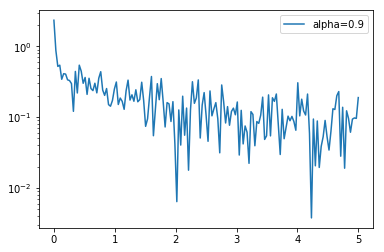

In [10]:
# np.linspace(start, stop, num, endpoint=True) 主要用来创建等差数列
# 下面表示将[0, 5]区间分成len(losses)份，endpoint=True表示包含end, 即左闭右闭
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='alpha=0.9')
plt.legend(loc='best')  # plt.legend（）函数主要的作用就是给图加上图例

### 附加：plt.legend() 函数主要的作用就是给图加上图例
可自行注释plt.legend() 行查看效果

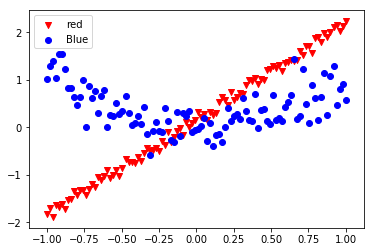

In [66]:
from matplotlib import pyplot as plt
import numpy as np
 
train_x = np.linspace(-1, 1, 100)
train_y_1 = 2*train_x + np.random.rand(*train_x.shape)*0.3
train_y_2 = train_x**2+np.random.randn(*train_x.shape)*0.3
 
plt.scatter(train_x, train_y_1, c='red', marker='v' )
plt.scatter(train_x, train_y_2, c='blue', marker='o' )
plt.legend(["red","Blue"])
plt.show()

### 改变$\alpha$的值, 查看loss在下降过程中的震荡程度

In [67]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 初始化梯度平方项
sqrs = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
    
# 开始训练
losses = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        # im = Variable(im)
        # label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        rmsprop(net.parameters(), sqrs, 1e-3, 0.999) # 学习率设为 0.001，alpha 设为 0.999   # 参数更新
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0:
            losses.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'.format(e, train_loss / len(train_data)))

end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.420096
epoch: 1, Train Loss: 0.177771
epoch: 2, Train Loss: 0.140892
epoch: 3, Train Loss: 0.121009
epoch: 4, Train Loss: 0.106453
使用时间: 32.25651 s


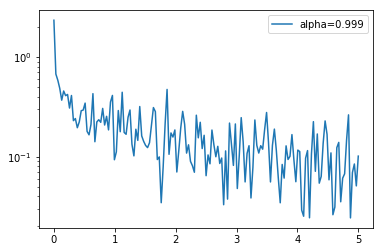

In [68]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='alpha=0.999')
plt.legend(loc='best')

### 使用pytorch 内置的 rmsprop 的方法，非常简单，只需要调用 torch.optim.RMSprop() 就可以了

In [69]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3, alpha=0.9)
    
# 开始训练

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        # im = Variable(im)
        # label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  # 参数更新
        # 记录误差
        train_loss += loss.item()
    print('epoch: {}, Train Loss: {:.6f}'.format(e, train_loss / len(train_data)))

end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.371187
epoch: 1, Train Loss: 0.166077
epoch: 2, Train Loss: 0.122253
epoch: 3, Train Loss: 0.100654
epoch: 4, Train Loss: 0.088559
使用时间: 30.69010 s


### 8.3 Adagrad

Adagrad可以自动变更学习率

### 8.4 Adadelta

Adagrad算法存在三个问题
- 其学习率是单调递减的，训练后洗学习率非常小
- 需要手工设置一个全局的初始学习率
- 更新$x_t$时，左右两遍单位不统一

### 8.5 Adam

Adam是基于一阶梯度来优化随机目标函数的算法

Adam名字来源于：Adaptive Moment Estimation 自适应矩估计，本质上是带动量的RMSProp

### 8.6 Adamax

Adamax优化器来自于Adam的论文的section7，该方法是基于无穷范数的Adam方法的变体

## 9 线性回归
$$
y = wx + b
$$

假定给定一条模拟直线的点，每个点偏移这条直线很小的范围，可以用随机函数来模拟这个随机的偏移

首先定义一个随机种子，基本不影响随机数的值，也可以不定义随机种子。

这里用numpy 的随机函数，不用torch提供的随机函数。生成200个X和y，模拟参数$w$为0.5

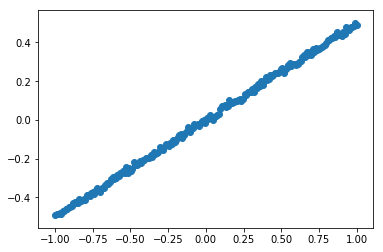

In [75]:
import torch
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 200)
y = 0.5*x + 0.2*np.random.normal(0, 0.05, (200, ))
plt.scatter(x, y)
plt.show()

In [132]:
# 转成 Tensor
# x_ = torch.from_numpy(x)
# y_ = torch.from_numpy(y)
# x_.requires_grad = True
# x_ = x_.float()
# # x_.dtype = torch.FloatTensor()
x_ = torch.Tensor(x.reshape(200, 1))
y_ = torch.Tensor(y.reshape(200, 1))
x_.requires_grad = True

In [133]:
x_.dtype

torch.float32

In [140]:
x_.shape

torch.Size([200, 1])

In [134]:
# 1 -> 1 神经网络
import torch.nn as nn
model = nn.Sequential(
    nn.Linear(1, 1)
    )
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
loss_function = nn.MSELoss()

In [135]:
# 看一下模型参数
model.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)>

In [136]:
x_.requires_grad

True

In [138]:
# 训练
for _ in range(300):
    # 前向传播
    out = model(x_)
    loss = loss_function(out, y_)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print('Train Loss: {:.6f}'.format(loss.item()))

Train Loss: 0.000090


### 绘图

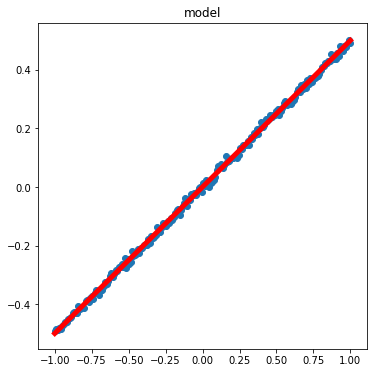

In [153]:
plt.figure(1, figsize=(20, 6))
plt.subplot(131)
plt.title('model')
plt.scatter(x_.data, y_.data)
plt.plot(x_.data, out.data, 'r-', lw=5)
plt.show()

### 看一下训练好的参数值, 可以发现$w$为0.4997 非常接近真实值0.5

In [161]:
for one in model.parameters():
    print(one)

Parameter containing:
tensor([[0.4997]], requires_grad=True)
Parameter containing:
tensor([0.0003], requires_grad=True)


## 10. numpy矩阵的保存

在经常性读取大量的数值文件时(比如深度学习训练数据),可以考虑现将数据存储为Numpy格式,然后直接使用Numpy去读取,速度相比为转化前快很多.

nm.npy 是文件名称

In [167]:
import numpy as np

a = np.array([[1, 2], [3, 4]])
a

array([[1, 2],
       [3, 4]])

In [168]:
a.shape

(2, 2)

In [169]:
# 保存
np.save("nm.npy", a)

In [170]:
# load
aa = np.load("nm.npy")
aa

array([[1, 2],
       [3, 4]])

## 11. 模型的保存和导入

每次定义和训练一个模型都要花费较长的时间，我们希望有一种方式可以讲训练好的模型和参数保存下来，下一次使用的时候直接导入模型和参数，就跟一个已经训练好的神经网络模型一样。

PyTorch提供了保存和导入方法。

### 11.1 模型保存
```python
# 保存整个神经网络的结构和模型参数
torch.save(model, 'my_model.pkl')
# 只保存神经网络的模型参数
torch.save(model.state_dict(), 'my_model_params.pkl')

```

### 11.2 导入模型
```python
model = torch.load('my_model.pkl')
```